<a id="top"></a> 

# Basic Visualizations and Descriptive Statistics of Spike Train Data

<div class="alert alert-block alert-info">
_**Synopsis**_ <br><br>

**Data:** Spontaneous spiking activity from a retinal neuron in culture, exposed to low-light and high-light environments.
<br>

**Goal:** Visualize spike trains, compute and interpret descriptive statistics, and build simple models of interspike interval distributions as a function of the ambient light level.
<br>

**Tools:** Raster plots, interspike interval histograms, firing rate, autocorrelograms, maximum likelihood estimation, Kolmogorov-Smirnov plots.
</div>

* [Introduction](#.)
* [Data analysis](#data-analysis)
    1. [Visual inspection](#visual-inspection)
    2. [Examining the Interspike Intervals](#isi)
    3. [Examining Binned Spike Increments](#bsi)
    4. [Computing autocorrelations for the Increments](#autocorrelations)
    5. [Computing Autocorrelations of the ISIs](#acISI)
* [Summary](#summary)
* [Appendix: Spike Count Mean and Variance for a Poisson Process](#appendix)

## Introduction

Neurons in the retina typically respond to patterns of light displayed over small sections of the visual field. However, when retinal neurons are grown in culture and held under constant light and environmental conditions, they will still spontaneously fire action potentials. In a fully functioning retina, this spontaneous activity is sometimes described as background firing activity, which is modulated as a function of visual stimuli. It is useful to understand the properties of this background activity in order to determine in future experiments how these firing properties are affected by specific stimuli.

### Case Study Data

A researcher examining the background firing properties of one of these neurons contacts you to discuss his data. He records the spiking activity in one of two states, with the room lights off (low ambient light levels) or with the room lights on (high ambient light levels). He would like to collaborate with you to determine whether there is a difference in background firing between these two conditions, and whether one environment is more conducive to future experimental analyses. He records the spiking activity for 30 seconds in each condition.

### Goal

Typically the first step in any data analysis involves visualizing and using simple descriptive statistics to characterize pertinent features of the data. For time series data that take on a continuous value at each time point, like the field potentials analyzed in earlier chapters, we typically start by simply plotting each data value as a function of time. For spike train data, things can become a bit more complicated. One reason for this is that there are multiple equivalent ways to describe the same spike train data. The data could be stored as a sequence of spike times; as a sequence of waiting times between spikes, or interspike intervals; or as a discrete time series indicating the number of spikes in discrete time bins. Knowing how to manipulate and visualize spike train data using all these different representations is the first step to understanding the structure present in the data and is the primary goal of this chapter.

### Tools

We develop tools in this chapter to visualize spike train data and to provide basic statistical methods appropriate for analyzing spike trains.

<a id="data-analysis"></a>
       
## Data Analysis

<a id="visual-inspection"></a>

Our data analysis begins with visual inspection. We load the ECoG data into Python and plot them by issuing the following commands: 

In [1]:
# Prepare the modules and plot settings
import scipy.io as sio
import matplotlib.pyplot as plt
import warnings
from matplotlib.pyplot import xlabel, ylabel, plot, show, title
from matplotlib import rcParams
%matplotlib inline

In [2]:
rcParams['figure.figsize'] = (12,3)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
data = sio.loadmat('Ch8-spikes-1.mat')  # Load the ECoG data

<div class="alert alert-block alert-info">

**Q.** How can we extract the variables of interest from `data`? Hint: Consider the `keys()` method.

</div>

You should find two non-private variables in the `data` dictionary:

`SpikesLow`: spike times over 30 s in the low ambient light condition
`SpikesHigh`: spike times over 30 s in the high ambient light condition

We can take these two variables from `data` so that we can work with them directly.

<div class="alert alert-block alert-warning">

Recall that the `loadmat()` function outputs a dictionary that contains the variables in the .mat file along with some additional information about the file. 

</div>

In [4]:
SpikesLow = data['SpikesLow'][0]
SpikesHigh = data['SpikesHigh'][0]

Each variable is a single vector that gives a set of increasing spike times for the associated condition. The two vectors are of different sizes because the neuron fired a different number of spikes in each condition.

<div class="alert alert-block alert-info">

<p>
    
**Q.** What is the size of the vector `SpikesLow`?

</p>

<p>
    
**A.** To answer this in Python, we use the command

    `SpikesLow.shape`

Python returns the answer
    
    `(750,)`
    
which reveals that `SpikesLow` is a vector with 750 elements (i.e., an array with 750 rows and 1 column). We could also have used `len(SpikesLow)` here since we are working with a vector (1-D) rather than a multidimensional array. Our collaborator who collected the data told us that each row holds a single spike time, and we continue to consider the implications of this statement.

</p>

</div>

<div class="alert alert-block alert-info">

**Q.** What is the size of the vector `SpikesHigh`?

</div>

Inspection of the sizes of the vectors `SpikesLow` and `SpikesHigh` reveals an important fact: the neuron fires more in the high-light condition. To make this observation more concrete, let’s compute the firing rate ($f$), defined mathematically as

$$
f = \frac{n}{T},
\tag{1}
$$

where $n$ is the number of spikes over the time interval $T$.

<div class="alert alert-block alert-info">

<p>
    
**Q.** What is the firing rate $f$ of the neuron recorded in the low ambient light condition?

</p>

<p>
    
**A.** To answer this question, we must first define two quantities of interest: $n$ and $T$. We consider here the entire duration of the recording, so $T = 30$ (our collaborator recorded the spiking activity for 30 s in each condition). During this interval, we found that the vector `SpikesLow` contains 750 spikes. With these two pieces of information, we may compute the firing rate.

</p>

</div>

In [5]:
T = 30
n = len(SpikesLow)
f = n / T

print('f =', f)

f = 25.0


This tells us that the firing rate is 25 spikes per second, or 25 Hz.

<div class="alert alert-block alert-info">

**Q.** Is this single number a good representation of the spike train data? What if the spiking changes dramatically throughout the recording?

</div>

<div class="alert alert-block alert-info">

**Q.** What is the firing rate of the neuron recorded in the high ambient light condition? 

</div>

These calculations allow us to compute a simple number representative of one aspect of the data: the firing rate over the entire duration of the recording. Do the two datasets exhibit a statistically significant change in the firing structure between conditions? Or, does the difference in firing rates lie within the range of expected fluctuations between any two trials of random spiking data? To answer these types of questions, we need to develop statistical methods that are appropriate for analyzing spike trains. Let’s look at the data more carefully and visualize the structure of the spiking in the low ambient light condition. Motivated by the results of the previous chapters, it may be tempting to visualize the spike train by simply plotting the `SpikesLow` variable,

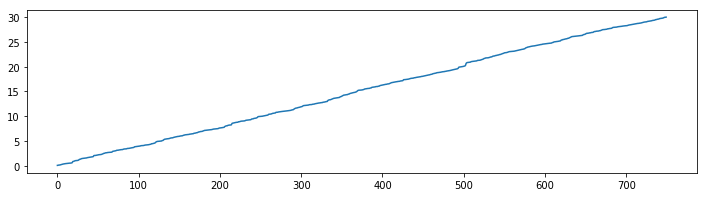

In [15]:
plot(SpikesLow)
show()

<div class="alert alert-block alert-info">

<p>
    
**Q.** What went wrong here? How do we interpret this plot?

</p>

<p>
    
**A.** These data are stored as a sequence of $N$ time stamps representing an increasing sequence of times at which the neuron spiked. When we run the plot command with only one input vector, we plot an index that runs from 1 to $n$ (the length of the vector) on the $x$-axis against the numerical values in that vector on the $y$-axis. Therefore the plot shows an increasing line where the $x$-axis represents the spike number and the $y$-axis represents the spike time. Notice that the vector ends at an $x$-axis value of 750, which corresponds to the length of the vector. Also, the values on the $y$-axis range from 0 to 30; these correspond to times starting near 0 s and ending near 30 s, as we expect for the 30 s recording. Although this plot is not immediately useful, the results are consistent with our expectations for the data.

</p>

</div>

Instead of the data representation above, we would like to plot the spike train data as a set of points in a single row with $x$-coordinates that occur at the spike times. One way to produce such a plot is the following:

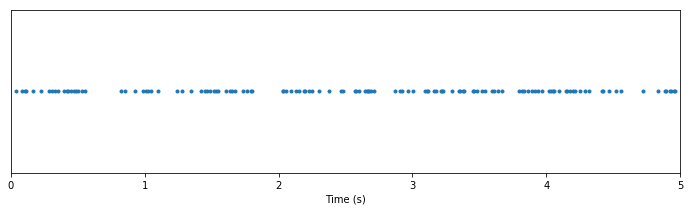

In [17]:
import numpy as np  # Import the NumPy module
plot(SpikesLow, np.ones_like(SpikesLow), '.')  # Plot spikes as a row,
plt.xlim([0, 5])                                # ... display times (0, 5) s
plt.xlabel('Time (s)')                          # ... label the x-axis
plt.yticks([])                                  # ... remove y-axis ticks
show()

<div class="alert alert-block alert-info">

<p>
    
**Q.** The first line of code imports the NumPy module. What’s happening in the second line of this code?

</p>

<p>
    
**A.** The plot function receives three inputs. The first input defines the $x$-axis values for the plot, which here are the spike times. The second input is itself a function: 


<pre>
<code>
    np.ones_like(SpikesLow). 
</code>
</pre>
  
The function `ones_like` produces an array filled entirely with 1s that is the same dimensions as `SpikesLow`. The last input to `plot` instructs Python to display the data using the dot symbol. To summarize, we’re calling the `plot` command to display 

<p>
<ui>

<li> $x$-axis values: spike times in the low ambient light condition

<li>$y$-axis values: 1

</ui>
</p>

as blue dots. The next two commands set the range of the $x$-axis (in this case from 0 s to 5 s) and provide an $x$-axis label. The last command removes the $y$-axis tick marks since they don't carry any real information in this case.

</p>

</div>

In the plot of the spike train above each spike time corresponds to a blue dot at a $y$-axis value of 1. The value on the $y$-axis is arbitrary. We could have chosen to use a $y$-axis value of 2 or -100 or 412. What matters is the $x$-axis, which indicates the time at which each spike occurs in the 5 s interval.

To compare the spiking in the low- and high-light conditions, we can plot both in the same figure:
<a id="fig:8.2b"></a>

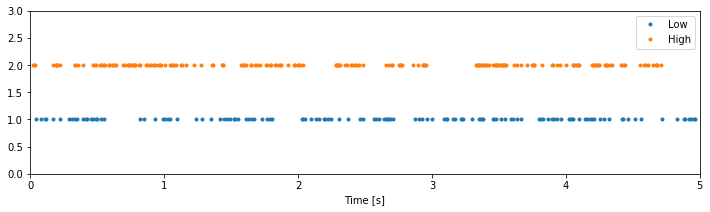

In [23]:
plot(SpikesLow, np.ones_like(SpikesLow), '.')  # Plot the low-light condition spikes
plot(SpikesHigh, 2 * np.ones_like(SpikesHigh), '.')  # ... and the high-light condition spikes 
plt.xlim([0, 5])              # Display times 0 to 5 s on the x-axis
plt.ylim([0, 3])              # ... and set the y-axis limits
xlabel('Time [s]')            # ... label the x-axis
plt.legend({'Low', 'High'})   # ... show a legend
show()

<div class="alert alert-block alert-info">

<p>
    
**Q.** What's happening in the fifth line of this code segment?

</p>

<p>
    
**A.** The fifth line of this code segment is similar to the second line, but it plots the data for the high ambient light condition. The first input to the `plot` function is the variable `SpikesHigh`. The second input to `plot` is a function; here we’re creating an array of 1s, this time with dimensions to match the variable `SpikesHigh`. Notice that we multiply this array by a scalar value of 2; this command acts to create a vector of 2s with the same dimensions as the vector `SpikesHigh`. The last input to `plot` indicates to display the data using another dot symbol. To summarize, here we’re calling the `plot` command to display

<p>
    <ul>
<li> x-axis values: spike times in the high ambient light condition <li> y-axis values: 2.
    </ul>
</p>

</p>

</div>

<div class="alert alert-block alert-info">

<p>
    
**Q.** Explain why the following command fails to execute:

<pre>
<code>
    plot(SpikesLow, np.ones_like(SpikesHigh), '.')
</code>
</pre>

</p>

</div>

With the data visualized in this way, we’re now able to ask an interesting question: What structure do you notice in the two spike trains [(figure)](#fig:8.2b)? At first glance, your answer might be “not much.” Spikes occur fairly regularly throughout the 5 s interval under both conditions. Perhaps a careful visual inspection suggests there are fewer spikes in the low-light than in the high-light condition. But the spike times themselves do not seem to be directly comparable between these conditions. Often, when we examine data from a stimulus response experiment, we expect to see regions where spiking activity increases or decreases as a function of a changing stimulus. In this case, the stimulus is the ambient light level, which remains constant over the entire experiment. How else can we analyze these data and identify differences in the spiking activity (if any) between the two conditions?

<div class="alert alert-block alert-info">

**Q.** Up to now, we've plotted a 5 s interval of data that begins at time 0 s. Through visual inspection, do you find similar conclusions for other 5 s intervals chosen from the data?

</div>

[[Back to top]](#top)

<a id="isi"></a>
### Examining the Interspike Intervals

So far, we have examined the long-term structure of the spiking over multiple seconds. Let’s now focus on the short-term structure that occurs within a single second or less. Instead of plotting 5 s of spike train data, let's plot an interval of 1 s:

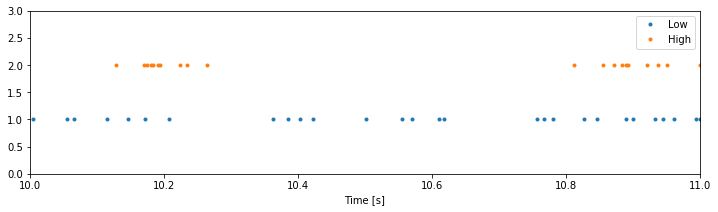

In [26]:
plot(SpikesLow, np.ones_like(SpikesLow), '.')  # Plot the low-light condition spikes
plot(SpikesHigh, 2 * np.ones_like(SpikesHigh), '.')  # ... and the high-light condition spikes 
plt.xlim([10, 11])              # Display times 0 to 5 s on the x-axis
plt.ylim([0, 3])              # ... and set the y-axis limits
xlabel('Time [s]')            # ... label the x-axis
plt.legend({'Low', 'High'})   # ... show a legend
show()

<div class="alert alert-block alert-info">

**Q.** The code above was copied and pasted from the previous section with one minor update to change the time interval. What adjustments did we need to make to the code so that we see an interval of 1 s instead of 5 s?

</div>

Inspecting smaller time intervals, you might notice bursts of spikes that cluster near each other in time, interspersed with longer periods that contain less spiking. These patterns of bursts and quiescence look different between the low- and high-light stimuli. Visual inspection is an important tool, but we would like a quantitative result. How might we compare this fine temporal structure in the two conditions?

One approach to further characterizing the differences in spiking between the two conditions is to transform the data. One of the most useful transformations focuses on the waiting times between the spikes, or interspike intervals (ISIs), instead of the spike times themselves. We can compute the ISIs for the two conditions as follows:

In [28]:
ISIsLow = np.diff(SpikesLow)  # Compute ISIs in the low-light condition
ISIsHigh = np.diff(SpikesHigh)  # Compute ISIs in the high-light condition

<div class="alert alert-block alert-info">

<p>
    
**Q.** How do these commands represent the ISIs of the data?

</p>

<p>
    
**A.** Let’s focus on the first command, which defines the variable ISIsLow. Here, we use the function diff with input SpikesLow. If you have not seen the com- mand diff before, look it up in MATLAB Help. Briefly, the diff command computes the difference between adjacent elements of the input. In this case, the vector SpikesLow represents the times at which spikes occur. Therefore, the differ- ence between adjacent elements of SpikesLow produces the time interval or waiting time between successive spikes. To further explore the concept of an ISI, let’s write the spike times as a vector,

$$
v = {t_1, t_2, t_3, ..., T_N}, 
\tag{2}
$$

where $t_i$ is the time of the $i^{th}$ spike. The difference between the first two adjacent elements of $v$ is 

$$
t_2 - t_1
\tag{3}
$$

By convention, the `diff()` function subtracts the first element from the second. In words, this difference represents the time of the second spike ($t_2$) minus the time of the first spike ($t_1$), or the first interspike interval in the data. The difference between the next two adjacent elements of $v$ is

$$
t_3 - t_2
\tag{4}
$$

which is the second ISI, and so on. In this way, `diff()` converts the spike times in the vector `SpikesLow` into interspike intervals saved in the variable `ISIsLow`.

</p>

</div>

<div class="alert alert-block alert-info">

**Q.** Consider the variables `ISIsLow` and `ISIsHigh`. How do the sizes of these variables compare to the sizes of the corresponding spike trains `SpikesLow` and `SpikesHigh`, respectively? *Hint:* Given $N$ spikes, how many ISIs must occur?

</div>

The variables `ISIsLow` and `ISIsHigh` are vectors, and we can visualize these vectors using the same tools we’ve applied to visualize vectors in other scenarios. For example, we may simply plot these vectors:

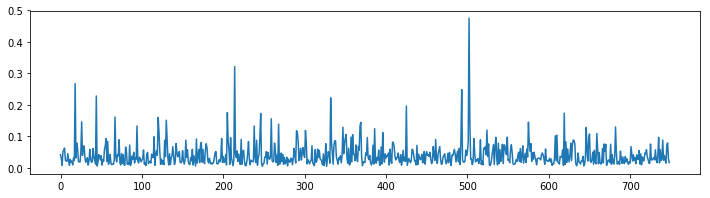

In [29]:
plot(ISIsLow)
show()

The x-axis is the vector index, which ranges from 1 to the length of the vector ISIsLow. The y-axis is the value of the ISI at each index. We see that the ISI values range from small times (less than 0.05 s) to large times (over 0.4 s). In this way, the visualization provides some insight into the ISI values for the low-light condition.

<div class="alert alert-block alert-info">

**Q.** Plot the ISI vector for the high-light condition and compare it to the ISI vector for the low-light condition. What similarities and differences do you notice in the ISIs from the two conditions?

</div>

<div class="alert alert-block alert-info">

**Q.** What is the smallest ISI you expect to observe for a neuron? Would you be surprised to find an ISI of less than 1 second? of less than 1 millisecond? of less than 1 nanosecond?

</div>

Plots of the ISI vectors provide some information about the data (e.g., the approximate range of the ISI values), but there’s more insight to be gained. To that end, let’s now implement another approach to visualizing these types of data: the histogram. The idea of a histogram is to count the number of occurrences of each value in the data. In this case, we count the number of times we observe an ISI value in different bins of time. Let’s define the time bins for the histogram. Inspection of the ISI data for the low-light condition reveals values that range from near 0 s to over 0.4 s. Therefore, we choose the following time bins:

Bin 0 [0.00 0.01] 

Bin 1 [0.01 0.02] 

Bin 2 [0.02 0.03] 

Bin 3 [0.03 0.04] 

Bin 4 [0.04 0.05] 

Bin 5 [0.05 0.06] 

Bin 6 [0.06 0.07] 

...

Bin N [0.49 0.50]

The bins begin at time 0 s and end at time 0.5 s, with a bin size of 0.01 s. The purpose of the histogram is to count the number of times the data values fall into each bin. Notice that we’ve chosen the range of bins to extend beyond the observed range of data ISIsLow; that’s fine, and we expect to count no values in the bins near 0.5 s. To further explore this counting process, let’s examine the first eight values of the data `ISIsLow`:

<div class="alert alert-block alert-warning">

Recall that Python uses *zero-based indexing*. This means that elements in arrays are numbered starting with 0, which is why we labeled the first bin "Bin 0" instead of "Bin 1".

</div>

In [32]:
ISIsLow[:8]

array([0.04098354, 0.02902169, 0.00746714, 0.05205904, 0.05553601,
       0.06204051, 0.02267623, 0.02132764])

We see that the first value of ISIsLow is approximately 0.0410. In which bin does this value belong? Examining the list of bins, we find that `ISIsLow[0]` lies in bin 4, so we increment the number of counts in bin 4 by 1. The second value of the vector `ISIsLow` (`ISIsLow[1]` $\approx$ 0.0290) lies in bin 2, so we increment the number of counts in bin 2 by 1. The third value, `ISIsLow[2]` $\approx$ 0.0075, lies in bin 0, so we increment the number of counts in bin 0 by 1. The fourth value, `ISIsLow[4]` $\approx$ 0.0521, lies in bin 5, so we increment the number of counts in bin 5 by 1. And the fifth value, `ISIsLow[4]` $\approx$ 0.0555, also lies in bin 5, so we again increment the number of counts in bin 5 by 1.

<div class="alert alert-block alert-info">

<p>
    
**Q.** At this point, for the first five entries of the vector `ISIsLow`, how many counts are there in each bin?

</p>

<p>
    
**A.** We find for the first five ISIs in the low-light condition, zero counts in all bins except

    <p>
Bin 0: 1 count <br>
Bin 2: 1 count <br>
Bin 4: 1 count <br>
Bin 5: 2 counts <br>
    
    </p>
    
Notice that only four bins have counts and that bin 5 has two counts; for the first five ISIs in the low-light condition, we observe two ISIs in the interval (0.05, 0.06).

</p>

</div>

<div class="alert alert-block alert-info">

**Q.** Repeat the binning procedure for the first eight ISIs observed in the high-light condition. Which bins have 1 or more counts for the first eight ISI values? What is the number of counts in each of these bins?

</div>

<div class="alert alert-block alert-info">

**Q.** Consider the first eight ISI values. In the previous question, you placed each of these values in a bin. Sum the counts across all bins. What do you find? Think about the value you compute; does the result make sense?

</div>

Of course, we’re free to choose any interval of bins for the histogram. In the preceding examples, we chose a bin size of 0.01 s = 10 ms. Based on our understanding of a neuron, we might instead choose to examine a smaller bin size, 0.001 s = 1 ms. Let’s do so now, and examine the histogram of all ISIs for the low-light condition. Of course, with enough patience, we could examine by hand each ISI value from the low-light condition and place each value in the correct 1 ms bin. However, this process would be time consuming and extremely error prone. Instead, the process of binning the ISI data is better done in Python. To create a histogram of all the ISI data in the low-light condition is straightforward:

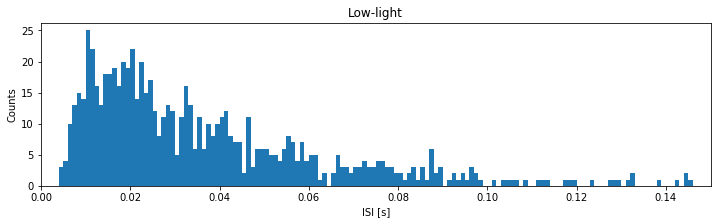

In [46]:
bins = np.arange(0, .5, 1e-3)  # Define the bins for the histogram
plt.hist(ISIsLow, bins)        # Plot the histogram of the ISI data
plt.xlim([0, 0.15])            # ... focus on ISIs from 0 to 150 ms
xlabel('ISI [s]')              # ... label the x-axis
ylabel('Counts')               # ... and the y-axis
title('Low-light')             # ... give the plot a title
plt.show()

In the first line of this code segment, we define the bins. These bins start at time 0 s and end at time 0.499 s, and the size of each bin is 0.001 s. We then call the function `hist()` with two inputs: the first input is the variable we’d like to examine (here, `ISIsLow`, the ISIs in the low-light condition), and the second input is the bins. The function `hist()` computes the histogram and displays the result. By setting the $x$-axis limit with `xlim()`, we’ve chosen to examine the ISI values from 0 ms to 150 ms. We’ve also labeled the axes in the resulting figure. Notice that the $x$-axis indicates the binned ISI intervals, while the $y$-axis indicates the number of counts in each bin.

<div class="alert alert-block alert-info">

<p>
    
**Q.** Repeat this procedure to create a histogram of the ISI data in the high-light condition. Use the same bins we applied in the low-light condition (i.e., a bin size of 1 ms, extending from 0 s to 0.5 s). What do you find? *Hint:* Compare your answer to plot above.

</p>

</div>

Let's visualize the distributions of ISIs in both conditions next to each other:

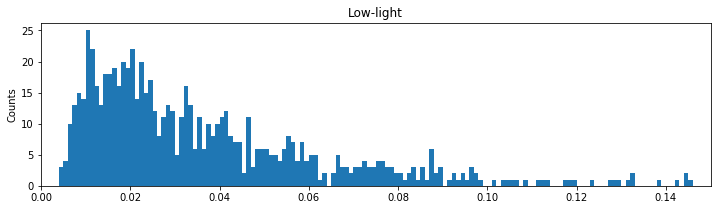

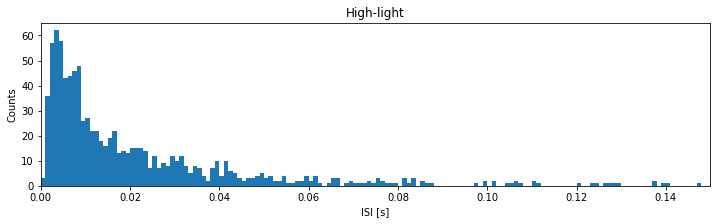

In [52]:
plt.hist(ISIsLow, bins)        # Plot the histogram of the low-light ISI data
plt.xlim([0, 0.15])            # ... focus on ISIs from 0 to 150 ms
ylabel('Counts')               # ... label the y-axis
title('Low-light')             # ... give the plot a title
plt.show()

plt.hist(ISIsHigh, bins)       # Plot the histogram of the high-light ISI data
plt.xlim([0, 0.15])            # ... focus on ISIs from 0 to 150 ms
xlabel('ISI [s]')              # ... label the x-axis
ylabel('Counts')               # ... and the y-axis
title('High-light')            # ... give the plot a title
plt.show()

<div class="alert alert-block alert-info">

**Q.** Describe the features of the two histograms. What features of the ISI distributions are similar for the two conditions? What features are most strikingly different?

</div>

In the ISI histogram of the low-light condition data, very few counts occur at small ISI values (near 0 ms) and high ISI values (beyond approximately 100 ms). Instead, the distribution of counts is broadly peaked in the approximate interval 5–20 ms.

<div class="alert alert-block alert-info">

<p>
    
**Q.** What does the ISI distribution reveal about the spiking activity in the low-light condition? From this ISI distribution, could you sketch a spike train consistent with these data?

</p>

<p>
    
**A.** We conclude from the ISI distribution that many spikes are separated by time intervals 5–20 ms. So, we might be tempted to imagine near-periodic spiking with a period 5–20 ms:

<a id="fig:8.6a"></a>

![Cartoon representation of spiking activity.](imgs/8-6a.png "Near-periodic spiking, with period 5&mdash;20 ms.")

However, the histogram contains additional structure beyond the single broad peak. Indeed, the histogram has a long tail, with counts extending up to 150 ms. Therefore, the intervals between spikes are varied. We often see ISIs in the 5–20 ms interval, but we also find much longer ISIs (e.g., from 50 to 150 ms). The structure of the ISI histogram is consistent with bursting activity, which consists of intervals of rapid spiking interspersed with quiescence:

<a id="fig:8.6b"></a>

![Cartoon representation of spiking activity.](imgs/8-6b.png "Bursting activity, with both short and long intervals between spikes.")

The intervals of rapid spiking produce many shorter ISIs, and the longer intervals produce (typically fewer) longer ISIs. We may conceptualize a bursting neuron as having two time scales: fast and slow. From the shape of the histogram of the low-light condition, we conclude that the spike train data in the low-light condition are more consistent with bursting activity than with periodic, metronome-like spiking activity.
    
</p>

</div>

<div class="alert alert-block alert-info">

**Q.** What does the ISI distribution reveal about the spiking activity in the high-light condition? From this ISI distribution, could you sketch a spike train consistent with these data?

</div>

Let’s now consider the two ISI histograms representing the spiking activity from the two conditions. We note that both histograms show no ISI values below 0 ms. This is to be expected; the intervals between spikes cannot be negative. Both histograms also show broad peaks at 5–20 ms, indicating that a large number of short ISIs appear in the spike trains. In addition, both histograms possess long tails (i.e., counts of ISIs at larger bins, beyond 50 ms). A reasonable conclusion is that both neurons exhibit bursting activity, intervals of rapid spiking separated by periods of quiescence. However, a prominent difference exists between the ISI histograms in the two conditions. In the high-light condition, the proportion of small ISIs is much larger. The visualizations of the ISI histograms provide additional evidence of the similarities and differences in the spiking activity from the two conditions. We continue to investigate these two datasets—and build our scientific conclusions—in the next sections.

<div class="alert alert-block alert-info">

**Q.** We claim that the neuron exhibits bursting activity in both histograms. But clearly the two ISI histograms are different. How does the bursting activity differ in the low- and high-light conditions? *Hint:* Consider the impact of the large proportion of small ISIs in the high-light condition.

</div>

<div class="alert alert-block alert-info">

**Q.** So far, we’ve investigated two bin sizes: 10 ms and 1 ms. How do the shapes of the histograms above depend on the bin size used? Was 1 ms a good choice in this case? Why, or why not?

</div>

[Back to top](#top)
<a id="bsi"></a>
### Examining Binned Spike Increments



In [ ]:
from IPython.core.display import HTML
HTML('../style.css')